# Flights example

In [1]:
import pandas
import numpy as np

import raha

## 1. Instantiating the Detection and Correction Classes

In [2]:
from raha import analysis_utilities
app_1 = raha.Detection()
app_2 = raha.Correction()

# How many tuples would you label?
app_1.LABELING_BUDGET = 20
app_2.LABELING_BUDGET = 0

# Would you like to see the logs?
app_1.VERBOSE = True
app_2.VERBOSE = True

## 2. Instantiating the Dataset

In [3]:
dataset_dictionary = {
        "name": "flights",
        "path": "datasets/flights/dirty.csv",
        "clean_path": "datasets/flights/clean.csv"
    }
d = app_1.initialize_dataset(dataset_dictionary)
d.dataframe.head()

,tuple_id,src,flight,sched_dep_time,act_dep_time,sched_arr_time,act_arr_time
0,1,aa,AA-3859-IAH-ORD,7:10 a.m.,7:16 a.m.,9:40 a.m.,9:32 a.m.
1,2,aa,AA-1733-ORD-PHX,7:45 p.m.,7:58 p.m.,10:30 p.m.,
2,3,aa,AA-1640-MIA-MCO,6:30 p.m.,,7:25 p.m.,
3,4,aa,AA-518-MIA-JFK,6:40 a.m.,6:54 a.m.,9:25 a.m.,9:28 a.m.
4,5,aa,AA-3756-ORD-SLC,12:15 p.m.,12:41 p.m.,2:45 p.m.,2:50 p.m.


## 3. Generating Features and Clusters

In [4]:
app_1.run_strategies(d)
app_1.generate_features(d)
app_1.build_clusters(d)

I just load strategies' results as they have already been run on the dataset!


309 strategy profiles are collected.
40 Features are generated for column 0.
65 Features are generated for column 1.
62 Features are generated for column 2.
65 Features are generated for column 3.
71 Features are generated for column 4.
65 Features are generated for column 5.
86 Features are generated for column 6.
A hierarchical clustering model is built for column 0.
A hierarchical clustering model is built for column 1.
A hierarchical clustering model is built for column 2.
A hierarchical clustering model is built for column 3.
A hierarchical clustering model is built for column 4.
A hierarchical clustering model is built for column 5.
A hierarchical clustering model is built for column 6.


## 4. Interactive Tuple Sampling and Labeling
For the sake of time, we use the ground truth of the dataset to label tuples below.

In [5]:
%%capture
while len(d.labeled_tuples) < app_1.LABELING_BUDGET:
    app_1.sample_tuple(d)
    if d.has_ground_truth:
        app_1.label_with_ground_truth(d)

## 5. Propagating User Labels and Predicting the Labels

In [6]:
app_1.propagate_labels(d)
app_1.predict_labels(d)

The number of labeled data cells increased from 140 to 11650.
A classifier is trained and applied on column 0.
A classifier is trained and applied on column 1.
A classifier is trained and applied on column 2.
A classifier is trained and applied on column 3.
A classifier is trained and applied on column 4.
A classifier is trained and applied on column 5.
A classifier is trained and applied on column 6.


## 6. Initializing and Updating the Error Corrector Models

In [7]:
app_2.initialize_models(d)
app_2.initialize_dataset(d)
for si in d.labeled_tuples:
    d.sampled_tuple = si
    app_2.update_models(d)
    app_2.generate_features(d)
    app_2.predict_corrections(d)

The error corrector models are initialized.
The error corrector models are updated with new labeled tuple 555.
449472 pairs of (a data error, a potential correction) are featurized.
Prediction Method in this step:
    Column 3: Train
    Column 4: Train
    Column 5: Train
    Column 6: Train
Train sizes in this step:
    Column 3: 840
    Column 4: 2262
    Column 5: 1298
    Column 6: 832
Corrections applied in this step:
    Column 3: 875 Real changes: 875
    Column 4: 378 Real changes: 378
    Column 5: 932 Real changes: 932
    Column 6: 658 Real changes: 658
63% (2844 / 4489) of data errors are corrected.
The error corrector models are updated with new labeled tuple 1571.
454034 pairs of (a data error, a potential correction) are featurized.
Prediction Method in this step:
    Column 3: Train
    Column 4: Train
    Column 5: Train
    Column 6: Train
Train sizes in this step:
    Column 3: 840
    Column 4: 2269
    Column 5: 1304
    Column 6: 859
Corrections applied in this s

## 8. Evaluating the Data Cleaning Task

In [8]:
edp, edr, edf = d.get_data_cleaning_evaluation(d.detected_cells)[:3]
ecp, ecr, ecf = d.get_data_cleaning_evaluation(d.corrected_cells)[-3:]

evaluation_df = pandas.DataFrame(columns=["Task", "Precision", "Recall", "F1 Score"])
evaluation_df = evaluation_df.append({"Task": "Error Detection (Raha)", "Precision": "{:.2f}".format(edp), 
                                      "Recall": "{:.2f}".format(edr), "F1 Score": "{:.2f}".format(edf)}, ignore_index=True)
evaluation_df = evaluation_df.append({"Task": "Error Correction (Baran)", "Precision": "{:.2f}".format(ecp), 
                                      "Recall": "{:.2f}".format(ecr), "F1 Score": "{:.2f}".format(ecf)}, ignore_index=True)
evaluation_df.head()

/home/adrian/source/MA/raha/raha/dataset.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if correction_dictionary[cell] == actual_errors[cell]:


,Task,Precision,Recall,F1 Score
0,Error Detection (Raha),0.85,0.77,0.81
1,Error Correction (Baran),0.80,0.57,0.66


## Analyze the alternative repairs

In [9]:
number_of_repairs = len(d.correction_collection)
number_of_repairs_hist = dict()

for cell_repairs in d.correction_collection.values():
    num = len(cell_repairs)
    number_of_repairs_hist[num] = number_of_repairs_hist.get(num, 0) + 1

hist = [0] * (max(number_of_repairs_hist.keys()) + 1)
for num, count in number_of_repairs_hist.items():
    hist[num] = count

f"Histogram of the number of alternative repairs: {list(enumerate(hist))}"

'Histogram of the number of alternative repairs: [(0, 0), (1, 3163), (2, 268), (3, 2)]'

In [10]:
diff_collection = []

for corrections in d.correction_collection.values():
    if len(corrections) > 1:
        probabilities = list(sorted(corrections.values(), reverse=True))
        diffs = [a - b for a, b in zip(probabilities[:-1], probabilities[1:])]
        diff_collection.append(diffs)

In [11]:
first_diff_collection = [l[0] for l in diff_collection]

np.histogram(first_diff_collection,np.linspace(0.0,0.5,101))

(array([ 4, 77,  4,  2,  0,  2,  2,  0,  1,  0,  1,  1,  0,  8,  5,  2,  8,
         2, 13,  0,  3,  0,  0,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  6,
         0,  0,  0,  0,  2,  0,  0,  0,  5,  0, 12,  6,  0,  0,  0,  0,  1,
         4,  0,  0,  7,  0,  5,  8, 14,  4,  2,  0,  1,  9,  0,  0,  0,  0,
         0,  0, 18,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0, 21]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
        0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
        0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
        0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
        0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
        0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.3

In [12]:
second_probs = []

for corrections in d.correction_collection.values():
    if len(corrections) > 1:
        second_probability = list(sorted(corrections.values(), reverse=True))[1]
        second_probs.append(second_probability)

np.histogram(second_probs,np.linspace(0.5,1.0,101))

(array([30, 73, 29, 14, 20, 21, 17,  0,  0,  4,  1,  0, 18,  0,  1,  6,  9,
         3,  5,  0,  0,  0,  2,  0,  0,  0,  0,  6,  0,  0,  0,  5,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535, 0.54 ,
        0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 , 0.585,
        0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625, 0.63 ,
        0.635, 0.64 , 0.645, 0.65 , 0.655, 0.66 , 0.665, 0.67 , 0.675,
        0.68 , 0.685, 0.69 , 0.695, 0.7  , 0.705, 0.71 , 0.715, 0.72 ,
        0.725, 0.73 , 0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 , 0.765,
        0.77 , 0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805, 0.81 ,
        0.815, 0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.8

In [13]:
correct_repairs = d.get_actual_errors_dictionary()
error_repaired_cells = [cell for cell, correction in d.corrected_cells.items() if cell in correct_repairs and correction != correct_repairs[cell]]

In [14]:
f"Number of incorrectly repaired cells: {len(error_repaired_cells)}"

'Number of incorrectly repaired cells: 363'

In [15]:
correct_repair_available = 0

for cell in error_repaired_cells:
    if correct_repairs[cell] in d.correction_collection[cell].keys():
        correct_repair_available += 1

f"Number of incorrectly repaired cells, where the correct repair is among the alternative repairs: {correct_repair_available}"

'Number of incorrectly repaired cells, where the correct repair is among the alternative repairs: 57'

In [16]:
correct_repair_probs = []

for cell in error_repaired_cells:
    if correct_repairs[cell] in d.correction_collection[cell]:
        correct_repair_probs.append(d.correction_collection[cell][correct_repairs[cell]])

np.histogram(correct_repair_probs,np.linspace(0.5,1.0,101))

(array([0, 2, 2, 4, 8, 0, 1, 0, 0, 4, 0, 0, 0, 0, 1, 5, 9, 3, 0, 0, 0, 0,
        2, 0, 0, 0, 0, 6, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535, 0.54 ,
        0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 , 0.585,
        0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625, 0.63 ,
        0.635, 0.64 , 0.645, 0.65 , 0.655, 0.66 , 0.665, 0.67 , 0.675,
        0.68 , 0.685, 0.69 , 0.695, 0.7  , 0.705, 0.71 , 0.715, 0.72 ,
        0.725, 0.73 , 0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 , 0.765,
        0.77 , 0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805, 0.81 ,
        0.815, 0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.845, 0.85 , 0.855,
        0.86 , 0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 , 0.895, 0.9  ,
        0.905, 0.91

## Analyze confidence vs error probability

In [17]:
import importlib
from raha import analysis_utilities
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.ion()

In [27]:
importlib.reload(analysis_utilities)

<module 'raha.analysis_utilities' from '/home/adrian/source/MA/raha/raha/analysis_utilities.py'>

In [19]:
repair_confidence_df = analysis_utilities.get_correction_confidence_df(d)

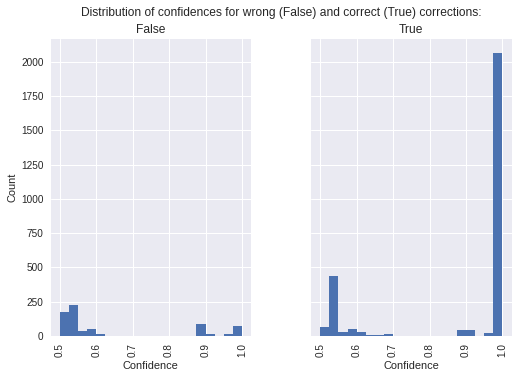

In [20]:
analysis_utilities.correction_confidence_distributions(repair_confidence_df)

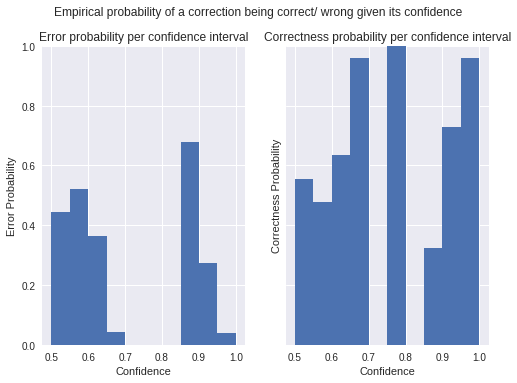

In [25]:
analysis_utilities.correction_correctness_by_confidence(repair_confidence_df, number_of_bins=10)

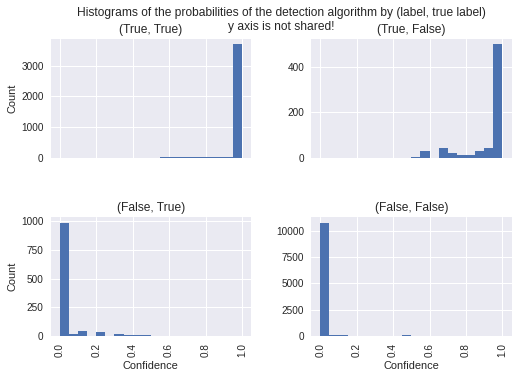

In [31]:
analysis_utilities.detection_evaluation(d)

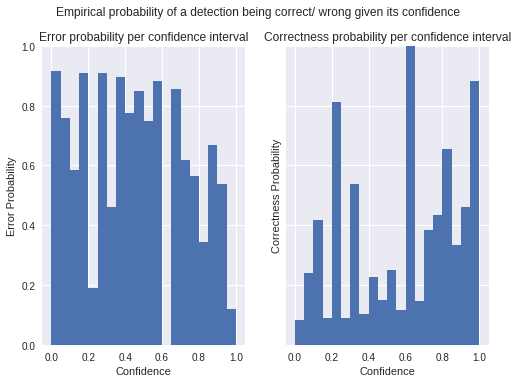

In [32]:
analysis_utilities.detection_correctness_by_confidence(d,number_of_bins=20)

## Misc

In [124]:
correction_confidence_df = analysis_utilities.get_correction_confidence_df(d, actual_errors)

In [125]:
correction_confidence_df.shape[0]

3380

In [126]:
(correction_confidence_df["confidence"] < 0.98).sum()

1138

In [131]:
f = analysis_utilities.correction_confidence_distributions(correction_confidence_df)
f.savefig("confidence_histogram.svg")

In [132]:
f = analysis_utilities.correction_correctness_by_confidence(correction_confidence_df, 10)
f.savefig("confidence_probability.svg")

In [129]:
print(analysis_utilities.result_analysis(d.dataframe, d.corrected_cells))

Changed attributes: [(3, 'sched_dep_time'), (4, 'act_dep_time'), (5, 'sched_arr_time'), (6, 'act_arr_time')]
Number of changed cells: 3380
Number of changed tuples: 1717
% of tuples changed: 72.26All changes:
       row  column value_before value_after    type_before     type_after  \
0      134       3                7:55 a.m.  <class 'str'>  <class 'str'>   
1      665       3   12:00 p.m.  12:00 a.m.  <class 'str'>  <class 'str'>   
2      714       3                8:35 a.m.  <class 'str'>  <class 'str'>   
3      806       3                6:45 a.m.  <class 'str'>  <class 'str'>   
4      866       3                7:05 a.m.  <class 'str'>  <class 'str'>   
...    ...     ...          ...         ...            ...            ...   
3375   416       6               11:56 a.m.  <class 'str'>  <class 'str'>   
3376  1302       6               11:56 a.m.  <class 'str'>  <class 'str'>   
3377  1566       6               11:56 a.m.  <class 'str'>  <class 'str'>   
3378  1752       6   

In [134]:
analysis_utilities.explain_detection(d, (1396, 4))

Original Value: '8:30 p.m.'
Label: 1
Confidence: 0.9997257024930141
Cell belongs to cluster (Column 4, Cluster 6)
Total number of cells in this cluster: 9
Cell was labeled by cluster label extension with label 1
Other cells in the same cluster (sample of max 5 cells):
(1789, 4): '2:04 p.m.' Features: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
(2081, 4): '2:04 p.m.' Features: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
(842, 4): '2:04 p.m.' Features: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0

In [135]:
analysis_utilities.alternative_corrections_overview(d, (1396, 4))

Correction: 8:39 p.m.
Correction confidence: 0.5531369592231153
Alternative corrections and their confidence values: {'8:39 p.m.': 0.5531369592231153}


In [15]:
analysis_utilities.get_repair_features(d, (50, 3))

value 0       0.000000
value 1       0.000000
value 2       0.000000
value 3       0.000000
value 4       0.000000
value 5       0.000000
value 6       0.000000
value 7       0.000000
vicinity 0    0.000000
vicinity 1    0.000000
vicinity 2    1.000000
vicinity 3    0.000000
vicinity 4    0.000000
vicinity 5    0.000000
vicinity 6    1.000000
domain        0.052249
dtype: float64

In [17]:
analysis_utilities.get_repair_features(d, (52, 3))


value 0       0.000000
value 1       0.000000
value 2       0.000000
value 3       0.000000
value 4       0.000000
value 5       0.000000
value 6       0.000000
value 7       0.000000
vicinity 0    0.000000
vicinity 1    0.000000
vicinity 2    1.000000
vicinity 3    0.000000
vicinity 4    0.000000
vicinity 5    0.000000
vicinity 6    0.000000
domain        0.011905
dtype: float64

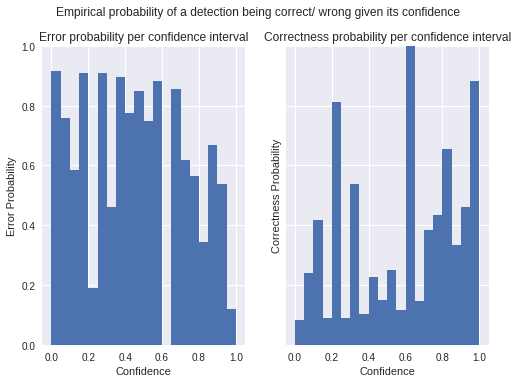